In [1]:
import numpy as np
import tables as tb

import matplotlib.pyplot as pl
%matplotlib inline

%config Completer.use_jedi = False

# MacOS
%config InlineBackend.figure_format="retina"

In [2]:
def read_hdf5(path,datasets,group='/'):
    with tb.open_file(path, 'r') as f:
        if isinstance(datasets,str):
            # Just one dataset, read it as an array
            data = f.get_node(f'{group}/{datasets}').read()
        else:
            # Assume nodes is an iterable of dataset names under group
            data = dict([ (name,f.get_node(f'{group}/{name}').read()) for name in datasets])
    return data

In [237]:
# This should point to a "full tree" output from PCHTrees

tree_file = '../examples/basic/output_tree_basic.001.hdf5'

In [4]:
!h5ls $tree_file

Header                   Group
OutputTimes              Group
Parameters               Group
Powerspec                Group
TreeHalos                Group
TreeTable                Group


In [5]:
!h5ls $tree_file/OutputTimes

DeltaCrit                Dataset {128}
ExpansionFactor          Dataset {128}
Redshift                 Dataset {128}


In [6]:
zred = read_hdf5(tree_file,'/OutputTimes/Redshift')

In [7]:
!h5ls $tree_file/TreeTable

Length                   Dataset {10}
RootMass                 Dataset {10}
StartOffset              Dataset {10}
TreeID                   Dataset {10}


In [8]:
# Offset and length of each tree in the halo (node) arrays
tree_o = read_hdf5(tree_file,'/TreeTable/StartOffset')
tree_l = read_hdf5(tree_file,'/TreeTable/Length')

In [9]:
!h5ls $tree_file/TreeHalos

Group_M_Crit200          Dataset {1166168/Inf}
SnapNum                  Dataset {1166168/Inf}
SubhaloMass              Dataset {1166168/Inf}
TreeBranch               Dataset {1166168/Inf}
TreeDescendant           Dataset {1166168/Inf}
TreeFirstDescendant      Dataset {1166168/Inf}
TreeFirstProgenitor      Dataset {1166168/Inf}
TreeID                   Dataset {1166168/Inf}
TreeIndex                Dataset {1166168/Inf}
TreeIndexPCH             Dataset {1166168/Inf}
TreeMainProgenitor       Dataset {1166168/Inf}
TreeNextProgenitor       Dataset {1166168/Inf}


In [10]:
# The linking indices refer to each tree individually, they are not absolute
# indicies into the full array of nodes.

node_snap      = read_hdf5(tree_file,'/TreeHalos/SnapNum')
node_mass      = read_hdf5(tree_file,'/TreeHalos/SubhaloMass')
node_branch    = read_hdf5(tree_file,'/TreeHalos/TreeBranch')
node_main_prog = read_hdf5(tree_file,'/TreeHalos/TreeMainProgenitor')
node_next_prog = read_hdf5(tree_file,'/TreeHalos/TreeNextProgenitor')

In [11]:
# Choose a tree index
itree = 0

The "tree offset" and "tree length" arrays partition the nodes into blocks associated with each tree.

In [12]:
# Select the nodes in this tree. 
this_tree = slice(tree_o[itree],tree_o[itree]+tree_l[itree])
print(f'{len(node_snap[this_tree]):d} nodes in this tree')
print(f'{len(np.unique(node_branch[this_tree])):d} branches in this tree')

115033 nodes in this tree
9085 branches in this tree


# The main branch

## Follow the main branch (method 1, following pointers)

In this example, we plot the main branch mass history by using a loop to follow the chain of indices from the root node to the end of the main branch.

In [13]:
inode = 0 # First node in tree is always the root of the main branch

main_branch_mass = list()
main_branch_snap = list()
while inode >= 0:
    main_branch_mass.append(node_mass[this_tree][inode])
    main_branch_snap.append(node_snap[this_tree][inode])
    inode = node_main_prog[inode]
main_branch_mass = np.array(main_branch_mass)
main_branch_snap = np.array(main_branch_snap)

print(f'{len(main_branch_mass):d} nodes in the main branch')

111 nodes in the main branch


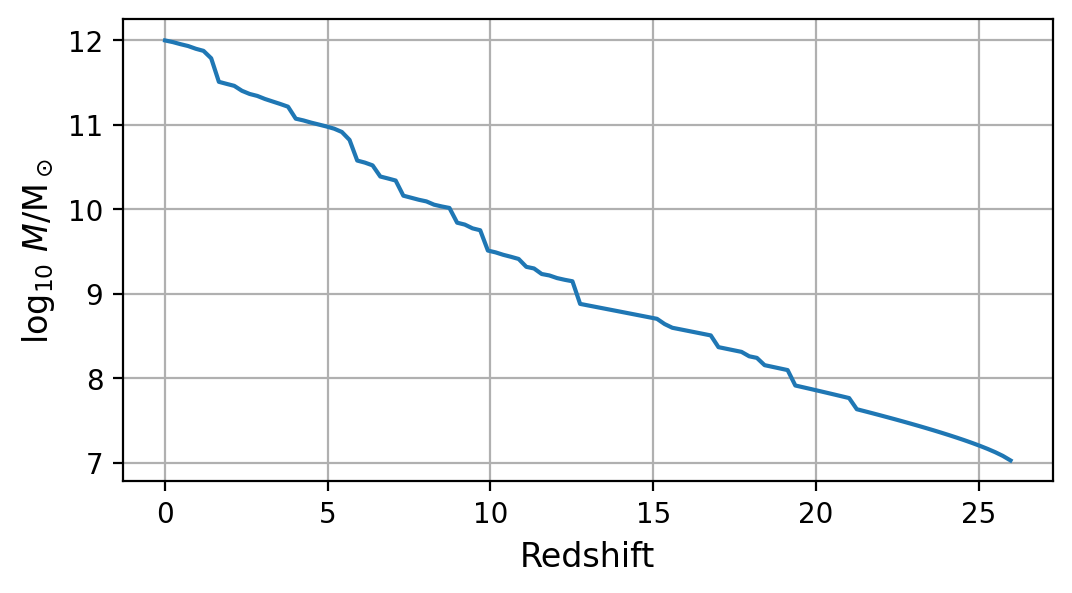

In [14]:
pl.figure(figsize=(6,3))
pl.plot(zred[::-1][main_branch_snap], np.log10(main_branch_mass))
ax = pl.gca()
pl.grid()
pl.xlabel('Redshift',fontsize=12)
pl.ylabel(r"$\log_{10}\,M/\mathrm{M_\odot}$",fontsize=12);

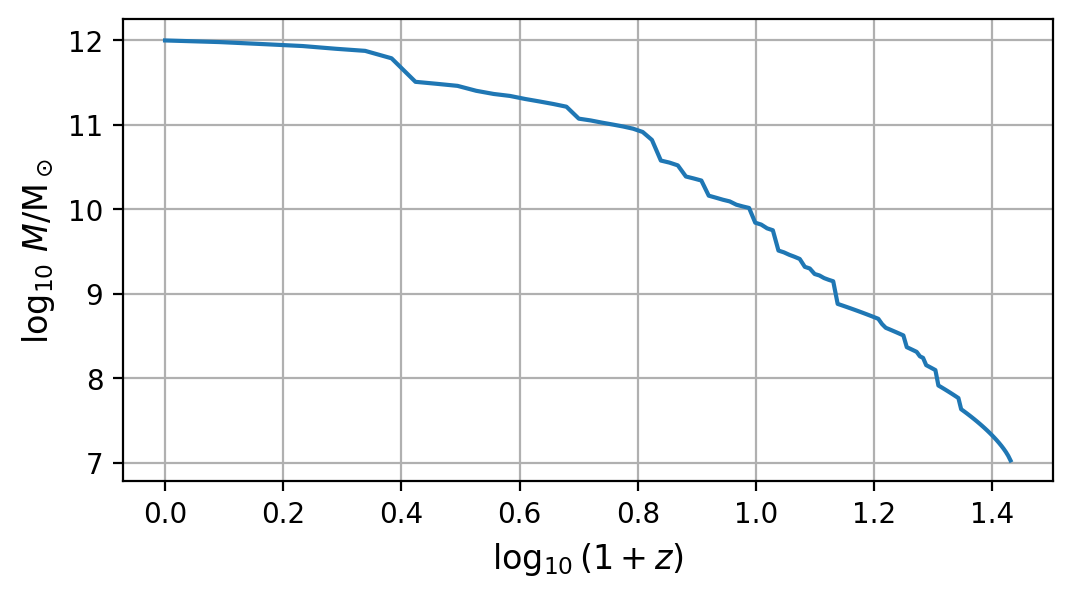

In [15]:
# Same thing but with log redshift axis

pl.figure(figsize=(6,3))
pl.plot(np.log10(1+zred[::-1][main_branch_snap]), np.log10(main_branch_mass))
ax = pl.gca()
pl.grid()
pl.xlabel(r"$\log_{10} (1+z)$",fontsize=12)
pl.ylabel(r"$\log_{10}\,M/\mathrm{M_\odot}$",fontsize=12);

## Follow the main branch (method 2, using branch index)

We don't have to use a loop; we can use the `node_branch` array to select all the halos in a particular branch at once.

Since we know the snapshot of each node (`node_snap`) we don't need to worry about the time order of the nodes.

In [16]:
inode = 0 # First node in tree is always the root of the main branch

# Branch of the first node
ibranch     = node_branch[this_tree][inode]
this_branch = np.flatnonzero(node_branch[this_tree] == ibranch)

main_branch_snap = node_snap[this_tree][this_branch]
main_branch_mass = node_mass[this_tree][this_branch]

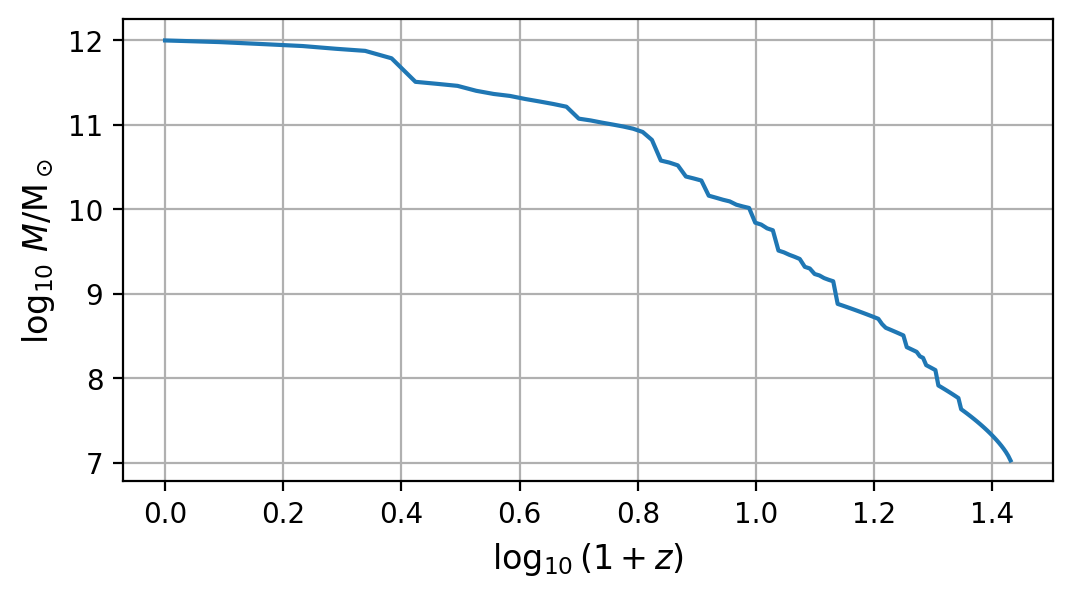

In [17]:
pl.figure(figsize=(6,3))
pl.plot(np.log10(1+zred[::-1][main_branch_snap]), np.log10(main_branch_mass))
ax = pl.gca()
pl.grid()
pl.xlabel(r"$\log_{10} (1+z)$",fontsize=12)
pl.ylabel(r"$\log_{10}\,M/\mathrm{M_\odot}$",fontsize=12);

# Globular clusters

Here we see how to compute the number of GCs based on the simplest (Mcrit, zcrit) model, using only the tree arrays.

In [18]:
z_crit = 10
m_crit = 1e8
s_crit = int(np.argmax(zred[::-1] < z_crit)) # First snapshot < z_crit

print(f"Critical snapshot {s_crit:d}")

# Group the nodes by their branch number
ibranches = np.unique(node_branch[this_tree])

# We'll save the details of each GC individually, rather than just counting.
cluster_branches = list() # Branch where the cluster formed
cluster_snaps    = list() # Snapshot of formation
cluster_mhost    = list() # Cluster mass

# Loop over branches 
for ibranch in ibranches:
    # Select the nodes in this branch
    in_branch = np.flatnonzero(node_branch[this_tree] == ibranch)
    
    # Apply the GC formation tests (no need to loop up or down the
    # branch, can use vectorized comparisons to check every node
    # in the branch in one operation):
    before_zcrit  = node_snap[this_tree][in_branch] < s_crit
    exceeds_mcrit = node_mass[this_tree][in_branch] > m_crit

    # Do any halos before z_crit exceed m_crit?
    if np.any(before_zcrit & exceeds_mcrit):
        # Store the branch for this cluster
        cluster_branches.append(int(ibranch))

        # Find the specific node that the cluster forms in (the first node in
        # the branch above Mcrit -- the enclosing "if" ensures that this node
        # must also be before zcrit.
        idx_form = np.argmin(exceeds_mcrit)
        cluster_snaps.append(int(node_snap[this_tree][in_branch][idx_form]))
        cluster_mhost.append(int(node_mass[this_tree][in_branch][idx_form]))

Critical snapshot 85


In [19]:
print(f'This tree forms {len(cluster_branches):d} GCs')

This tree forms 263 GCs


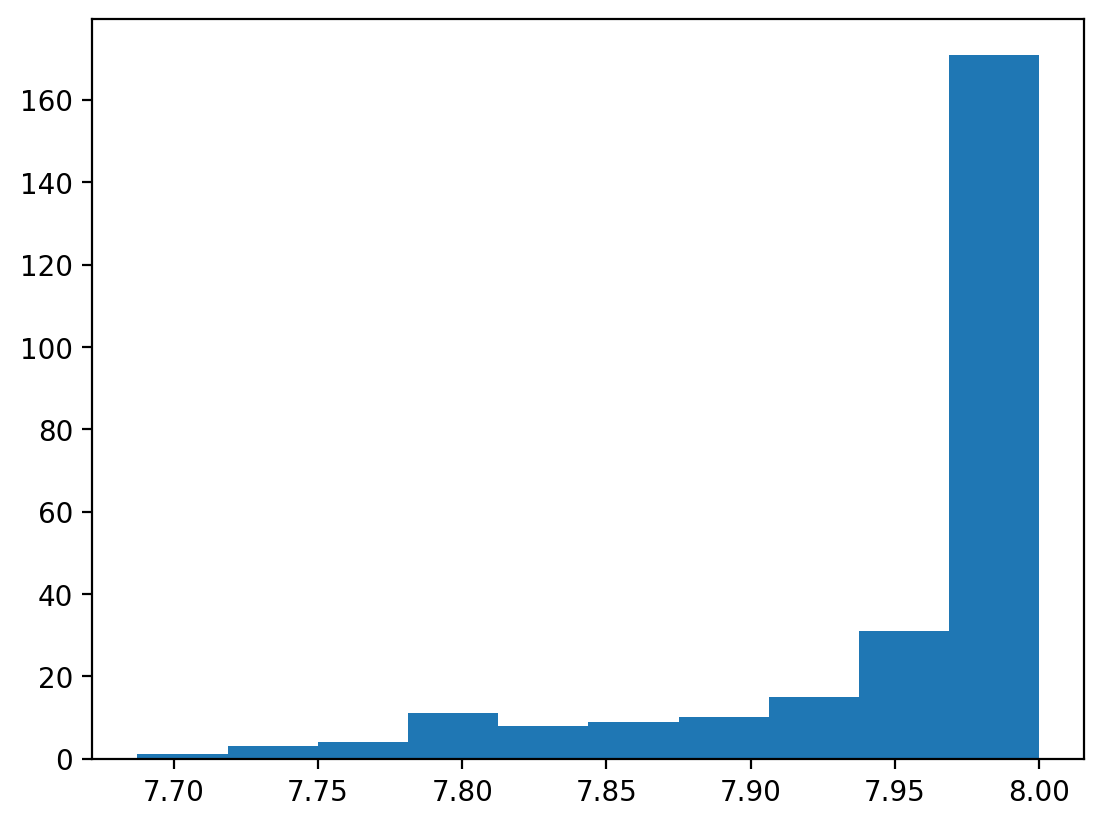

In [20]:
# Make a histogram of the host halo mass -- this should peak around Mcrit.
pl.hist(np.log10(cluster_mhost));

# The tail to lower mass is because we pick the last time *before* the 
# halo exceeds mcrit, rather than the first time *after* it exceeds 
# mcrit.

We can extend this to loop over all trees in the file:

In [231]:
%%time

cluster_count = np.zeros(len(tree_l))

for itree in range(0,len(tree_l)):
    this_tree = slice(tree_o[itree],tree_o[itree]+tree_l[itree])

    ibranches = np.unique(node_branch[this_tree])
    for ibranch in ibranches:
        in_branch = np.flatnonzero(node_branch[this_tree] == ibranch)
        
        before_zcrit  = node_snap[this_tree][in_branch] < s_crit
        exceeds_mcrit = node_mass[this_tree][in_branch] > m_crit
    
        # Do any halos before z_crit exceed m_crit?
        if np.any(before_zcrit & exceeds_mcrit):
            cluster_count[itree] += 1

CPU times: user 1.53 s, sys: 0 ns, total: 1.53 s
Wall time: 1.54 s


How many clusters in each tree?

In [232]:
cluster_count

array([263., 259., 242., 262., 247., 255., 253., 271., 275., 261.])

# Build tree

The following code builds a tree data structure from the arrays. 

In [23]:
class Node:
    def __init__(self, idx, mass, snap):
        self.idx        = idx           # Original index
        self.mass       = mass          # Node mass
        self.snap       = snap          # Node snapshot
        self.parent     = None          # Parent Node (or None)
        self.children   = list()        # List[Node], sorted by mass
        self.main_child = None          # The heaviest child (or None)
        self.next_dfs   = None          # Next node in DFS order

    def __repr__(self):
        return f"Node(idx={self.idx:8d}, mass={self.mass:8.3e}, snap={self.snap:4d})"
        
def build_tree(node_mass, node_snap, first_child, next_child):
    """
    This assumes no informative order of the input arrays.
    """
    n = len(node_mass)
    nodes = [Node(i, node_mass[i], node_snap[i]) for i in range(n)]

    # Step 1: Populate children and parents
    for i in range(n):
        child_idx = first_child[i]
        while child_idx != -1:
            child_node = nodes[child_idx]
            child_node.parent = nodes[i]
            nodes[i].children.append(child_node)
            child_idx = next_child[child_idx]

    # Step 2: Sort children by mass and set main_child
    for node in nodes:
        node.children.sort(key=lambda c: c.mass, reverse=True)
        node.main_child = node.children[0] if node.children else None

    # Step 3: Find the root
    # APC: This is a simple search in order until we don't find a parent
    # APC: Could shortcut this by identifying the root up from.
    root = next(node for node in nodes if node.parent is None)

    # Step 4: Assign next_dfs pointers using DFS order
    dfs_order = []

    def dfs(node):
        dfs_order.append(node)
        for child in node.children:
            dfs(child)

    dfs(root)

    for i in range(len(dfs_order) - 1):
        dfs_order[i].next_dfs = dfs_order[i + 1]

    return root

Try this out tou build the tree:

In [76]:
itree = 0
this_tree = slice(tree_o[itree],tree_o[itree]+tree_l[itree])

root = build_tree(node_mass[this_tree],
                  node_snap[this_tree],
                  node_main_prog[this_tree],
                  node_next_prog[this_tree])

We can define a "walk tree" function that looks like the Fortran version:

In [87]:
def walk_tree(node):
    if node.next_dfs is not None:
        return node.next_dfs
    else:
        return None

We can plot the mass along the main branch using this function:

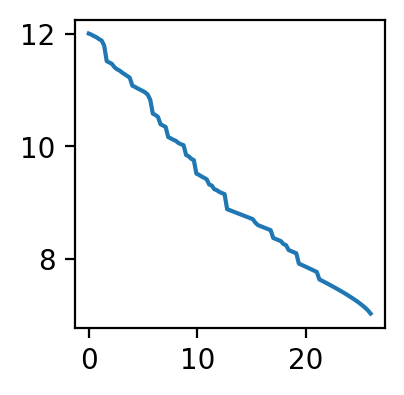

In [90]:
main_branch_mass = []
main_branch_snap = []

node = root
while node is not None:
    main_branch_mass.append(node.mass)
    main_branch_snap.append(node.snap)
    node = node.main_child

pl.figure(figsize=(2,2))
pl.plot(zred[::-1][main_branch_snap], np.log10(main_branch_mass));

A more "pythonic" version of the walk tree function is an iterator object:

In [124]:
class TreeNodeIterator():
    def __init__(self, root):
        self._root = root
        self._node = self._root
 
    def __iter__(self):
        return self
        
    def __next__(self):
        if self._node.next_dfs is None:
            raise StopIteration
        else:
            this_node  = self._node
            self._node = self._node.next_dfs    
            return this_node

    def reset(self):
        self._node = self._root

In [93]:
iter_tree = TreeNodeIterator(root)

This iterator object stores the current state of the iteraton. We can use the python iterator functions with this object, for example, to get the "next" node in the depth first order:

In [97]:
next(iter_tree)

Node(idx=       3, mass=8.586e+11, snap= 124)

In [98]:
next(iter_tree)

Node(idx=       4, mass=7.970e+11, snap= 123)

And so on. Here is the mian branch mass function with the iterator:

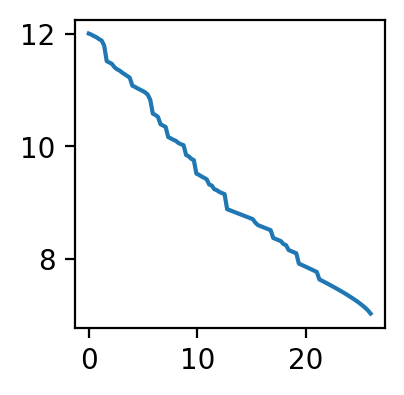

In [99]:
iter_tree = TreeNodeIterator(root)

main_branch_mass = list()
main_branch_snap = list()

for node in iter_tree:
    main_branch_mass.append(node.mass)
    main_branch_snap.append(node.snap)
    if node.main_child is  None:
        break
pl.figure(figsize=(2,2))
pl.plot(zred[::-1][main_branch_snap], np.log10(main_branch_mass));

If we only care about one branch, we can make this particular operation even simpler with a different iterator which stops at the end of a branch:

In [125]:
class BranchNodeIterator(TreeNodeIterator):
    def __next__(self):
        if self._node is None:
            raise StopIteration
        else:
            this_node  = self._node
            self._node = self._node.main_child
            return this_node

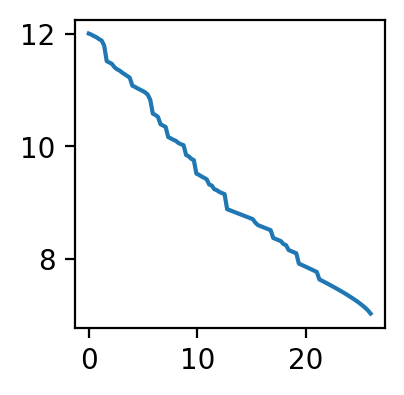

In [101]:
main_branch_mass = np.array([n.mass for n in BranchNodeIterator(root)])
main_branch_snap = np.array([n.snap for n in BranchNodeIterator(root)])

pl.figure(figsize=(2,2));
pl.plot(zred[::-1][main_branch_snap], np.log10(main_branch_mass));

Notice the following doesn't work -- can't re-use the same iterator!

In [74]:
branch_iter = BranchNodeIterator(root)
main_branch_mass = np.array([n.mass for n in branch_iter])
main_branch_snap = np.array([n.snap for n in branch_iter])
len(main_branch_mass), len(main_branch_snap)

(111, 0)

But we could do:

In [75]:
main_branch_mass = list()
main_branch_snap = list()
for n in BranchNodeIterator(root):
    main_branch_mass.append(n.mass)
    main_branch_snap.append(n.snap)

In [210]:
from collections import deque 

# This returns a branch iterator for each branch

class TreeBranchIterator():
    def __init__(self, root):
        self._root = root
        self._node = self._root
 
    def __iter__(self):
        return self
        
    def __next__(self):
        if self._node.next_dfs is None:
            raise StopIteration
        else:
            # Return an iterator for the current branch
            iterator_for_this_branch = BranchNodeIterator(self._node)

            # Update the pointer to the start of the next branch, by
            # following the DFS pointer from the leaf node of the current branch.
            last_node_in_this_branch = deque(BranchNodeIterator(self._node)).pop()
            self._node = last_node_in_this_branch.next_dfs    
            return iterator_for_this_branch

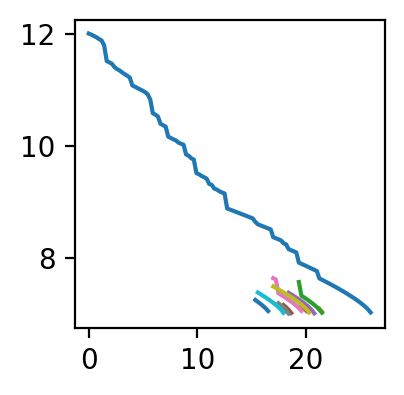

In [212]:
pl.figure(figsize=(2,2));

tree_branch_iterator = TreeBranchIterator(root)

n_branches_processed = 0

for branch_iterator in TreeBranchIterator(root):
    branch_mass = np.array([n.mass for n in branch_iterator])
    branch_iterator.reset()
    branch_snap = np.array([n.snap for n in branch_iterator])
    pl.plot(zred[::-1][branch_snap], np.log10(branch_mass));

    n_branches_processed += 1
    if n_branches_processed > 10:
        break

# Code summary

All the code in one place; the starting point for a self-contained python module. 

Some extra options and complexity added here.

At the end, there is an example of the mcrit,zcrit globular cluster counting using iterators over the tree data structure.

In [236]:
import numpy as np
import tables as tb

from collections import deque 

def read_hdf5(path,datasets,group='/'):
    with tb.open_file(path, 'r') as f:
        if isinstance(datasets,str):
            # Just one dataset, read it as an array
            data = f.get_node(f'{group}/{datasets}').read()
        else:
            # Assume nodes is an iterable of dataset names under group
            data = dict([ (name,f.get_node(f'{group}/{name}').read()) for name in datasets])
    return data

class PCHTreeFile():
    """
    """
    def __init__(self,path):
        """
        """
        self.node_snap      = read_hdf5(path,'/TreeHalos/SnapNum')
        self.node_mass      = read_hdf5(path,'/TreeHalos/SubhaloMass')
        self.node_branch    = read_hdf5(path,'/TreeHalos/TreeBranch')
        self.node_main_prog = read_hdf5(path,'/TreeHalos/TreeMainProgenitor')
        self.node_next_prog = read_hdf5(path,'/TreeHalos/TreeNextProgenitor')

        # Offset and length of each tree in the halo (node) arrays
        self.tree_o = read_hdf5(tree_file,'/TreeTable/StartOffset')
        self.tree_l = read_hdf5(tree_file,'/TreeTable/Length')

        self.ntrees = len(self.tree_l)

    def get_tree(self,itree):
        """
        Creates a tree data structure from the tree file for a given tree index.
        """
        node_sel = slice(self.tree_o[itree],
                         self.tree_o[itree]+self.tree_l[itree])
    
        extra_props = {'branch':self.node_branch[node_sel]}
        
        tree = _build_tree(self.node_mass[node_sel], 
                           self.node_snap[node_sel],
                           self.node_main_prog[node_sel],
                           self.node_next_prog[node_sel],
                           extra_props=extra_props)
        return tree
    
class Node:
    def __init__(self, idx, mass, snap, **extra_props):
        """
        Represents a single tree node.
        """
        self.idx        = idx           # Original index
        self.mass       = mass          # Node mass
        self.snap       = snap          # Node snapshot
        self.parent     = None          # Parent Node (or None)
        self.children   = list()        # List[Node], sorted by mass
        self.main_child = None          # The heaviest child (or None)
        self.next_dfs   = None          # Next node in DFS order

        for attr_name,attr_value in extra_props.items():
            setattr(self, attr_name, attr_value)

    def __repr__(self):
        return f"Node(idx={self.idx:8d}, mass={self.mass:8.3e}, snap={self.snap:4d})"

def _build_tree(node_mass, node_snap, first_child, next_child, extra_props=None):
    """
    Builds a single tree data structure from pointer arrays.
    
    This assumes no informative order of the input arrays.
    """
    n = len(node_mass)
    
    nodes = list()
    for i in range(n):
        if extra_props is not None:
            extra_props_this_node = dict( [(k,v[i]) for k,v in extra_props.items()] )
        else:
            extra_props_this_node = []
        nodes.append(Node(i, node_mass[i], node_snap[i], **extra_props_this_node))

    # Step 1: Populate children and parents
    for i in range(n):
        child_idx = first_child[i]
        while child_idx != -1:
            child_node = nodes[child_idx]
            child_node.parent = nodes[i]
            nodes[i].children.append(child_node)
            child_idx = next_child[child_idx]

    # Step 2: Sort children by mass and set main_child
    for node in nodes:
        node.children.sort(key=lambda c: c.mass, reverse=True)
        node.main_child = node.children[0] if node.children else None

    # Step 3: Find the root
    # APC: This is a simple search in order until we don't find a parent
    # APC: Could shortcut this by identifying the root up from.
    root = next(node for node in nodes if node.parent is None)

    # Step 4: Assign next_dfs pointers using DFS order
    dfs_order = []

    def dfs(node):
        dfs_order.append(node)
        for child in node.children:
            dfs(child)

    dfs(root)

    for i in range(len(dfs_order) - 1):
        dfs_order[i].next_dfs = dfs_order[i + 1]

    return root

class TreeNodeIterator():
    def __init__(self, root):
        self._root = root
        self._node = self._root
 
    def __iter__(self):
        return self
        
    def __next__(self):
        if self._node.next_dfs is None:
            raise StopIteration
        else:
            this_node  = self._node
            self._node = self._node.next_dfs    
            return this_node

    def reset(self):
        self._node = self._root

class BranchNodeIterator(TreeNodeIterator):
    def __next__(self):
        if self._node is None:
            raise StopIteration
        else:
            this_node  = self._node
            self._node = self._node.main_child
            return this_node
            
class TreeBranchIterator():
    def __init__(self, root):
        self._root = root
        self._node = self._root
 
    def __iter__(self):
        return self
        
    def __next__(self):
        """
        Returns an iterator along the next brnach
        """
        if self._node.next_dfs is None:
            raise StopIteration
        else:
            # Return an iterator for the current branch
            iterator_for_this_branch = BranchNodeIterator(self._node)

            # Update the pointer to the start of the next branch, by
            # following the DFS pointer from the leaf node of the current branch.
            last_node_in_this_branch = deque(BranchNodeIterator(self._node)).pop()
            self._node = last_node_in_this_branch.next_dfs    
            return iterator_for_this_branch

For testing the above:

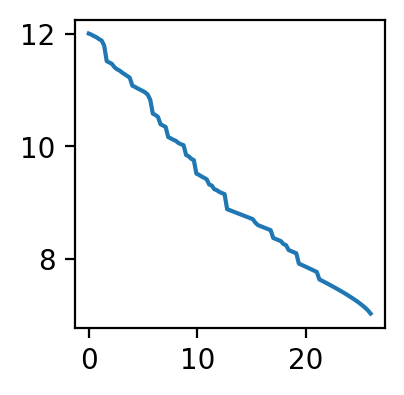

In [214]:
tree_data = PCHTreeFile('../examples/basic/output_tree_basic.001.hdf5')
tree_root = tree_data.get_tree(0)

main_branch_mass = np.array([n.mass for n in BranchIterator(tree_root)])
main_branch_snap = np.array([n.snap for n in BranchIterator(tree_root)])

pl.figure(figsize=(2,2));
pl.plot(zred[::-1][main_branch_snap], np.log10(main_branch_mass));

In [233]:
z_crit = 10
m_crit = 1e8
s_crit = int(np.argmax(zred[::-1] < z_crit)) # First snapshot < z_crit

tree_data = PCHTreeFile('../examples/basic/output_tree_basic.001.hdf5')

In [234]:
%time 
cluster_count = np.zeros(tree_data.ntrees)

for itree in range(0,tree_data.ntrees):
    tree_root = tree_data.get_tree(itree)
    tree_branches = TreeBranchIterator(tree_root)

    # In this case we do have to iterate up the branch
    for branch in tree_branches:
        for node in branch:
            # If we find a node > m_crit before s_crit, we must
            # have a cluster in the branch. In this simple case
            # we don't worry about which node exactly that is.
            if (node.snap < s_crit) and (node.mass > m_crit):
                cluster_count[itree] += 1
                break

CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 3.1 μs


In [235]:
cluster_count

array([263., 259., 242., 262., 247., 255., 253., 271., 275., 261.])